In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.price_forcasting import *

In [4]:
# load the dataset 
df=pd.read_csv('../data/price_with_features.csv')

In [ ]:
df.head()

In [ ]:
analyzer = OilPriceAnalysis(df)
analyzer.prepare_data(test_size=0.2)  # Using 20% of data for testing

Fitting ARIMA model...
ARIMA metrics: {'rmse': np.float64(33.4536381368727), 'mae': np.float64(27.347140054170637), 'r2': -1.6207139790070535}


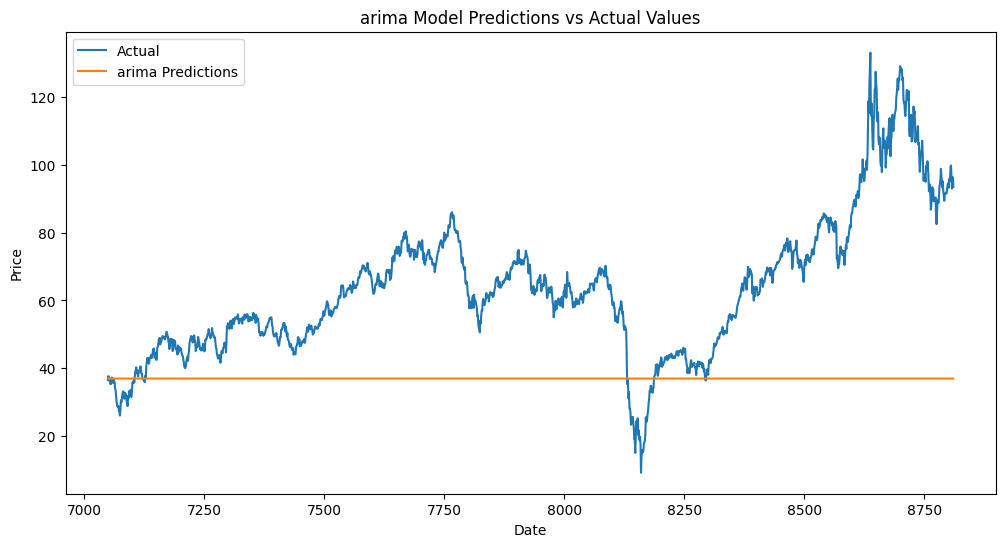

In [6]:
# ARIMA Model
print("Fitting ARIMA model...")
analyzer.fit_arima(order=(1,1,1))  # You can adjust the order parameters
print("ARIMA metrics:", analyzer.metrics.get('arima', 'Not available'))
analyzer.plot_results('arima')

In [7]:
# GARCH Model
print("\nFitting GARCH model...")
analyzer.fit_garch(vol_order=(1,1))  # You can adjust the volatility order
print("GARCH metrics:", analyzer.metrics.get('garch', 'Not available'))


Fitting GARCH model...
GARCH metrics: {'rmse': np.float64(0.03346001391515873), 'mae': np.float64(0.02512716056357726), 'r2': -1.2932085655217112}



Fitting VAR model...
Error calculating metrics for var: y_true and y_pred have different number of output (1!=4)
VAR metrics: Not available


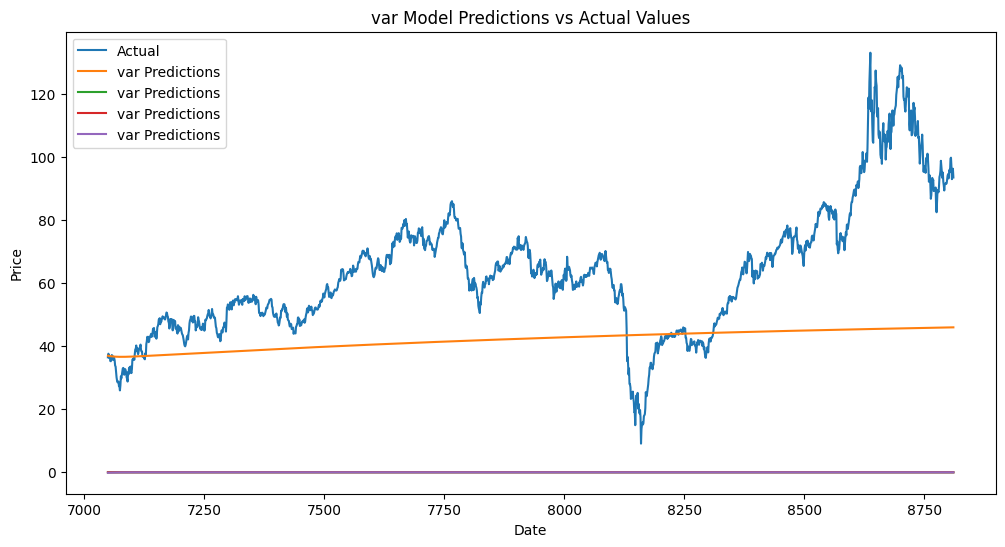

In [8]:
# VAR Model
print("\nFitting VAR model...")
analyzer.fit_var(maxlags=5)  # You can adjust the maximum lags
print("VAR metrics:", analyzer.metrics.get('var', 'Not available'))
analyzer.plot_results('var')

In [ ]:
# LSTM Model
print("\nFitting LSTM model...")
lstm_history = analyzer.fit_lstm(
    seq_length=60,  # Number of time steps to look back
    epochs=100,     # Number of training epochs
    batch_size=32   # Batch size for training
)
print("LSTM metrics:", analyzer.metrics.get('lstm', 'Not available'))
analyzer.plot_results('lstm')


Fitting LSTM model...


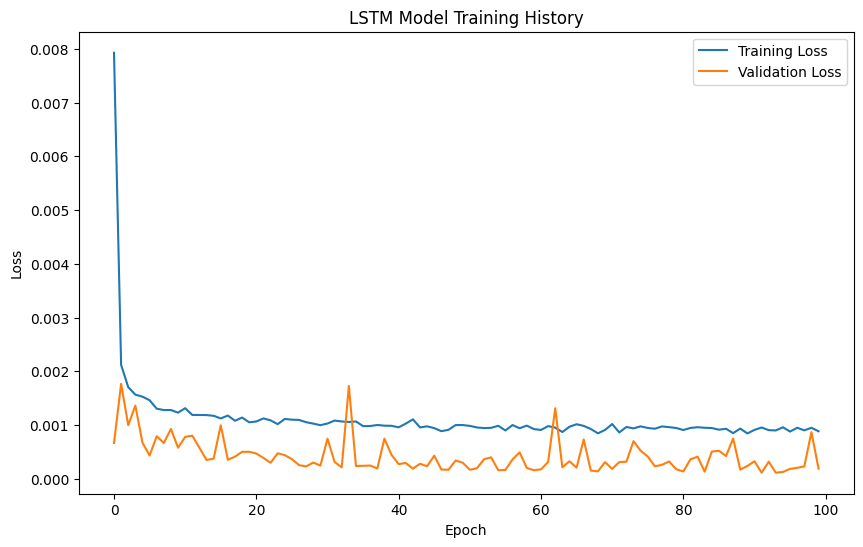

In [ ]:
# Plot LSTM training history
plt.figure(figsize=(10, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Perform cross-validation for LSTM
print("\nPerforming cross-validation for LSTM...")
cv_mean, cv_std = analyzer.cross_validate('lstm', n_splits=5)
print(f"Cross-validation RMSE: {cv_mean:.4f} (+/- {cv_std:.4f})")


Performing cross-validation for LSTM...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Cross-validation RMSE: 0.0222 (+/- 0.0160)


In [ ]:
# Compare all models
print("\nComparison of all models:")
metrics_df = pd.DataFrame.from_dict(analyzer.metrics, orient='index')
print(metrics_df)


Comparison of all models:
            rmse        mae        r2
arima  33.453638  27.347140 -1.620714
garch   0.033460   0.025127 -1.293209
lstm    2.456943   1.803970  0.985237


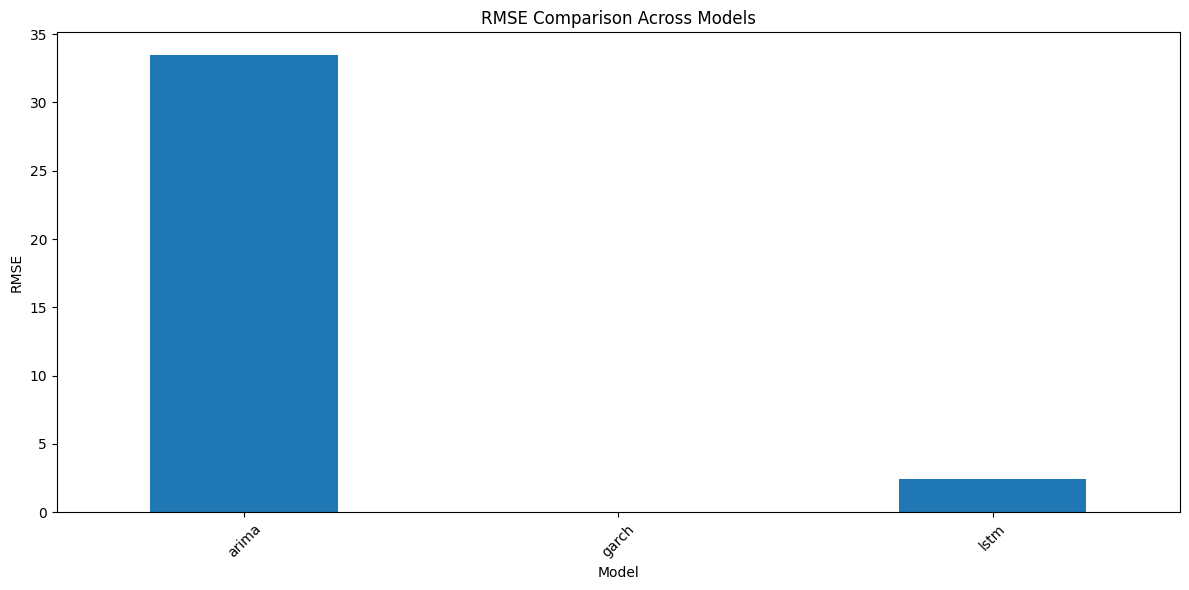

In [ ]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
metrics_df['rmse'].plot(kind='bar')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Optional: Integrate external data if you have any
"""
# Example of integrating external data:
external_data = pd.DataFrame({
    'gdp': [...],
    'inflation': [...],
    'oil_production': [...]
}, index=df.index)

analyzer.integrate_external_data(external_data)
"""

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Actual': analyzer.test['Price'],
    'ARIMA': analyzer.predictions.get('arima', np.nan),
    'VAR': analyzer.predictions.get('var', np.nan)['Price'] if isinstance(analyzer.predictions.get('var', np.nan), pd.DataFrame) else np.nan,
    'LSTM': analyzer.predictions.get('lstm', np.nan).flatten()
})
predictions_df.to_csv('model_predictions.csv')

In [ ]:
# Create a summary report
print("\nModel Performance Summary:")
print("-" * 50)
for model_name, metrics in analyzer.metrics.items():
    print(f"\n{model_name.upper()} Model:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"R²: {metrics['r2']:.4f}")


Model Performance Summary:
--------------------------------------------------

ARIMA Model:
RMSE: 33.4536
MAE: 27.3471
R²: -1.6207

GARCH Model:
RMSE: 0.0335
MAE: 0.0251
R²: -1.2932

LSTM Model:
RMSE: 2.4569
MAE: 1.8040
R²: 0.9852


In [ ]:
# def fit_arima_model(df, order=(1, 1, 1)):
#     # Fit ARIMA model to the 'Price' column
#     model = ARIMA(df['Price'], order=order)
#     arima_fit = model.fit()
#     print(arima_fit.summary())
#     return arima_fit

In [ ]:
#  # ARIMA model
# arima_fit = fit_arima_model(df)

In [ ]:
# arima_fit.plot_diagnostics(figsize=(10, 8))
# plt.show()